In [1]:
import numpy as np
import pandas as pd
import torch
import pickle

# LogME

In [2]:
import warnings
from tqdm import tqdm
import numpy as np
from numba import njit


@njit
def each_evidence(y_, f, fh, v, s, vh, N, D):
    """
    compute the maximum evidence for each class
    """
    epsilon = 1e-5
    alpha = 1.0
    beta = 1.0
    lam = alpha / beta
    tmp = (vh @ (f @ np.ascontiguousarray(y_)))
    for _ in range(11):
        # should converge after at most 10 steps
        # typically converge after two or three steps
        gamma = (s / (s + lam)).sum()
        # A = v @ np.diag(alpha + beta * s) @ v.transpose() # no need to compute A
        # A_inv = v @ np.diag(1.0 / (alpha + beta * s)) @ v.transpose() # no need to compute A_inv
        m = v @ (tmp * beta / (alpha + beta * s))
        alpha_de = (m * m).sum()
        alpha = gamma / (alpha_de + epsilon)
        beta_de = ((y_ - fh @ m) ** 2).sum()
        beta = (N - gamma) / (beta_de + epsilon)
        new_lam = alpha / beta
        if np.abs(new_lam - lam) / lam < 0.01:
            break
        lam = new_lam
    evidence = D / 2.0 * np.log(alpha) \
               + N / 2.0 * np.log(beta) \
               - 0.5 * np.sum(np.log(alpha + beta * s)) \
               - beta / 2.0 * (beta_de + epsilon) \
               - alpha / 2.0 * (alpha_de + epsilon) \
               - N / 2.0 * np.log(2 * np.pi)
    return evidence / N, alpha, beta, m


# use pseudo data to compile the function
# D = 20, N = 50
f_tmp = np.random.randn(20, 50).astype(np.float64)
each_evidence(np.random.randint(0, 2, 50).astype(np.float64), f_tmp, f_tmp.transpose(), np.eye(20, dtype=np.float64), np.ones(20, dtype=np.float64), np.eye(20, dtype=np.float64), 50, 20)


@njit
def truncated_svd(x):
    u, s, vh = np.linalg.svd(x.transpose() @ x)
    s = np.sqrt(s)
    u_times_sigma = x @ vh.transpose()
    k = np.sum((s > 1e-10) * 1)  # rank of f
    s = s.reshape(-1, 1)
    s = s[:k]
    vh = vh[:k]
    u = u_times_sigma[:, :k] / s.reshape(1, -1)
    return u, s, vh
truncated_svd(np.random.randn(20, 10).astype(np.float64))


class LogME(object):
    def __init__(self, regression=False):
        """
            :param regression: whether regression
        """
        self.regression = regression
        self.fitted = False
        self.reset()

    def reset(self):
        self.num_dim = 0
        self.alphas = []  # alpha for each class / dimension
        self.betas = []  # beta for each class / dimension
        # self.ms.shape --> [C, D]
        self.ms = []  # m for each class / dimension

    def _fit_icml(self, f: np.ndarray, y: np.ndarray):
        """
        LogME calculation proposed in the ICML 2021 paper
        "LogME: Practical Assessment of Pre-trained Models for Transfer Learning"
        at http://proceedings.mlr.press/v139/you21b.html
        """
        fh = f
        f = f.transpose()
        D, N = f.shape
        v, s, vh = np.linalg.svd(f @ fh, full_matrices=True)

        evidences = []
        self.num_dim = y.shape[1] if self.regression else int(y.max() + 1)
        for i in tqdm(range(self.num_dim)):
            y_ = y[:, i] if self.regression else (y == i).astype(np.float64)
            evidence, alpha, beta, m = each_evidence(y_, f, fh, v, s, vh, N, D)
            evidences.append(evidence)
            self.alphas.append(alpha)
            self.betas.append(beta)
            self.ms.append(m)
        self.ms = np.stack(self.ms)
        return np.mean(evidences)

    def _fit_fixed_point(self, f: np.ndarray, y: np.ndarray):
        """
        LogME calculation proposed in the arxiv 2021 paper
        "Ranking and Tuning Pre-trained Models: A New Paradigm of Exploiting Model Hubs"
        at https://arxiv.org/abs/2110.10545
        """
        N, D = f.shape  # k = min(N, D)
        if N > D: # direct SVD may be expensive
            u, s, vh = truncated_svd(f)
        else:
            u, s, vh = np.linalg.svd(f, full_matrices=False)
        # u.shape = N x k
        # s.shape = k
        # vh.shape = k x D
        s = s.reshape(-1, 1)
        sigma = (s ** 2)

        evidences = []
        self.num_dim = y.shape[1] if self.regression else int(y.max() + 1)
        for i in range(self.num_dim):
            y_ = y[:, i] if self.regression else (y == i).astype(np.float64)
            y_ = y_.reshape(-1, 1)
            x = u.T @ y_  # x has shape [k, 1], but actually x should have shape [N, 1]
            x2 = x ** 2
            res_x2 = (y_ ** 2).sum() - x2.sum()  # if k < N, we compute sum of xi for 0 singular values directly

            alpha, beta = 1.0, 1.0
            for _ in range(11):
                t = alpha / beta
                gamma = (sigma / (sigma + t)).sum()
                m2 = (sigma * x2 / ((t + sigma) ** 2)).sum()
                res2 = (x2 / ((1 + sigma / t) ** 2)).sum() + res_x2
                alpha = gamma / (m2 + 1e-5)
                beta = (N - gamma) / (res2 + 1e-5)
                t_ = alpha / beta
                evidence = D / 2.0 * np.log(alpha) \
                           + N / 2.0 * np.log(beta) \
                           - 0.5 * np.sum(np.log(alpha + beta * sigma)) \
                           - beta / 2.0 * res2 \
                           - alpha / 2.0 * m2 \
                           - N / 2.0 * np.log(2 * np.pi)
                evidence /= N
                if abs(t_ - t) / t <= 1e-3:  # abs(t_ - t) <= 1e-5 or abs(1 / t_ - 1 / t) <= 1e-5:
                    break
            evidence = D / 2.0 * np.log(alpha) \
                       + N / 2.0 * np.log(beta) \
                       - 0.5 * np.sum(np.log(alpha + beta * sigma)) \
                       - beta / 2.0 * res2 \
                       - alpha / 2.0 * m2 \
                       - N / 2.0 * np.log(2 * np.pi)
            evidence /= N
            m = 1.0 / (t + sigma) * s * x
            m = (vh.T @ m).reshape(-1)
            evidences.append(evidence)
            self.alphas.append(alpha)
            self.betas.append(beta)
            self.ms.append(m)
        self.ms = np.stack(self.ms)
        return np.mean(evidences)

    _fit = _fit_fixed_point

    def fit(self, f: np.ndarray, y: np.ndarray):
        """
        :param f: [N, F], feature matrix from pre-trained model
        :param y: target labels.
            For classification, y has shape [N] with element in [0, C_t).
            For regression, y has shape [N, C] with C regression-labels
        :return: LogME score (how well f can fit y directly)
        """
        if self.fitted:
            warnings.warn('re-fitting for new data. old parameters cleared.')
            self.reset()
        else:
            self.fitted = True
        f = f.astype(np.float64)
        if self.regression:
            y = y.astype(np.float64)
            if len(y.shape) == 1:
                y = y.reshape(-1, 1)
        return self._fit(f, y)

    def predict(self, f: np.ndarray):
        """
        :param f: [N, F], feature matrix
        :return: prediction, return shape [N, X]
        """
        if not self.fitted:
            raise RuntimeError("not fitted, please call fit first")
        f = f.astype(np.float64)
        logits = f @ self.ms.T
        if self.regression:
            return logits
        return np.argmax(logits, axis=-1)

# Define some useful function

In [3]:
def array_rank_transform(arr):       
    sorted_list = sorted(arr, reverse = True)
    rank = 1
    # seed initial rank as 1 because that's first item in input list
    sorted_rank_list = [1]
    for i in range(1, len(sorted_list)):
        if sorted_list[i] != sorted_list[i-1]:
            rank += 1
        sorted_rank_list.append(rank)
    rank_list = []
    for item in arr:
        for index, element in enumerate(sorted_list):
            if element == item:
                rank_list.append(sorted_rank_list[index])
                # we want to break out of inner for loop
                break
    return rank_list
def process_log_prob(s):
  s = s.split(",")
  s[-1] = s[-1].split("]")[0]
  return [int(char) for char in s]

# Import features

## import features

In [14]:
sample_id = 0
model_layer = 0

In [13]:
import pickle
with open("/content/drive/MyDrive/LogME-CTC/PR_hubert_ranking_layer_0.pkl", "rb") as fp:   # Unpickling
 pickle_feature = pickle.load(fp)
sample_feature = pickle_feature[sample_id][0].cpu().numpy()
sample_feature.shape # the feature of sample 1

(1695, 768)

## import log_probs

In [19]:
log_probs = pd.read_table(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/layer_{model_layer}_log_prob.txt",header=None,sep = "[",names = ["filename","log_probs_arg_max"])
log_probs["log_probs_arg_max"] = log_probs["log_probs_arg_max"].apply(process_log_prob)
print(len(log_probs["log_probs_arg_max"][sample_id]),log_probs["log_probs_arg_max"][sample_id])

1695 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 60, 60, 0, 0, 0, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 0, 0, 0, 0, 0, 61, 0, 0, 0, 0, 61, 38, 38, 0, 30, 30, 0, 0, 0, 0, 0, 37, 37, 0, 0, 0, 0, 0, 0, 28, 0, 0, 60, 60, 0, 0, 0, 0, 0, 43, 43, 0, 0, 59, 59, 0, 0, 0, 0, 0, 0, 31, 31, 0, 58, 0, 0, 69, 69, 0, 0, 39, 0, 0, 0, 69, 0, 62, 0, 0, 0, 0, 61, 0, 0, 0, 0, 34, 0, 0, 0, 0, 69, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 70, 70, 40, 0, 69, 0, 0, 0, 0, 0, 23, 0, 52, 52, 0, 0, 0, 0, 0, 0, 0, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 61, 11, 0, 0, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 46, 60, 0, 0, 0, 0, 0, 11, 0, 49, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 49, 25, 25, 25, 0, 39, 0, 72, 0, 0, 0, 0, 0, 0, 46, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 61, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 0, 36, 0, 0, 15, 15, 58, 0, 38, 38, 0, 30, 30, 0, 59, 59, 0, 0, 0, 0, 0, 0, 52, 52, 0, 0, 0, 60, 0, 0, 0, 11, 0, 0, 0, 0, 0, 36, 36, 0, 0, 0, 12, 50,

## import labels

In [42]:
labels = pd.read_table(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/PR_labels.txt",header=None,sep = "[",names = ["filename","labels"])
labels["labels"] = labels["labels"].apply(process_log_prob)
print(len(labels["labels"][sample_id]),labels["labels"][sample_id])

385 [11, 59, 60, 43, 11, 70, 34, 61, 11, 25, 38, 30, 37, 28, 59, 61, 59, 60, 43, 59, 30, 69, 34, 25, 62, 61, 34, 23, 11, 47, 70, 40, 62, 23, 52, 62, 59, 9, 61, 11, 59, 36, 9, 46, 60, 11, 49, 9, 49, 25, 25, 39, 59, 46, 70, 21, 11, 61, 68, 25, 36, 15, 58, 38, 30, 59, 52, 60, 11, 47, 36, 12, 50, 46, 60, 11, 49, 72, 70, 31, 36, 71, 67, 61, 11, 49, 21, 61, 26, 28, 58, 70, 31, 60, 43, 24, 28, 46, 61, 26, 11, 48, 15, 36, 15, 49, 38, 30, 36, 40, 50, 37, 30, 72, 59, 40, 58, 45, 34, 48, 72, 46, 58, 34, 61, 11, 49, 62, 58, 40, 24, 40, 50, 37, 47, 39, 60, 48, 10, 49, 71, 11, 36, 9, 46, 24, 30, 30, 9, 49, 25, 47, 34, 25, 42, 46, 58, 34, 61, 11, 49, 48, 40, 59, 61, 30, 9, 49, 25, 48, 40, 59, 39, 72, 69, 9, 49, 25, 30, 57, 68, 47, 48, 40, 59, 61, 30, 38, 9, 58, 42, 46, 58, 28, 59, 70, 29, 47, 9, 49, 25, 38, 39, 59, 59, 40, 59, 61, 30, 45, 6, 49, 61, 34, 47, 30, 9, 49, 25, 38, 39, 59, 59, 40, 59, 61, 30, 9, 49, 25, 48, 40, 59, 61, 30, 24, 6, 58, 11, 47, 72, 59, 48, 41, 62, 38, 67, 48, 62, 43, 69, 49, 

# Calculate framewise LogME score

In [44]:
sample_feature 

array([[ 0.04512627,  0.01023865, -0.1481481 , ..., -0.02199807,
         0.03295837, -0.18067814],
       [ 0.0737367 , -0.03919121, -0.16521475, ..., -0.008058  ,
         0.02810761, -0.09261499],
       [ 0.09614426, -0.00959983, -0.1540026 , ..., -0.00088303,
         0.00736331, -0.19846904],
       ...,
       [ 0.09329338,  0.07843408, -0.10890211, ..., -0.03273496,
         0.01545777,  0.02987148],
       [ 0.07648429,  0.07236906, -0.09836462, ..., -0.01984293,
         0.02295214,  0.04652519],
       [ 0.07576406,  0.09435707, -0.08395141, ..., -0.03279691,
         0.02353182,  0.02419101]], dtype=float32)

In [56]:
label_set = list(set(labels["labels"][sample_id])) #有被predict的label
feat_index = np.where(log_probs["log_probs_arg_max"][sample_id] == label_set[1]) #應該被predict成那個label的feature

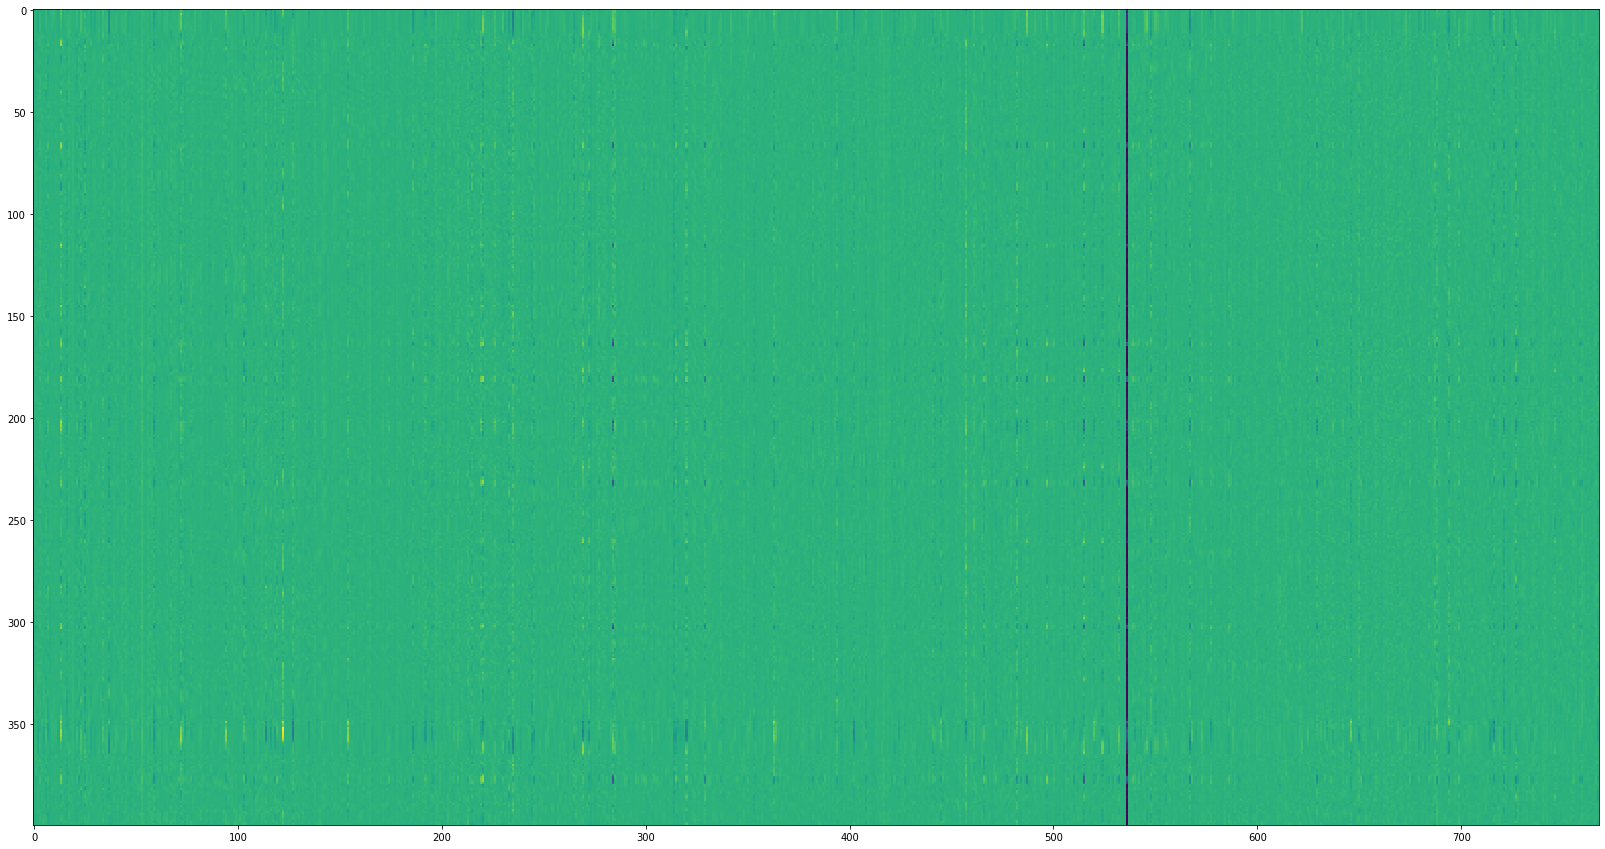

In [60]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (50,15))
plt.imshow(sample_feature[:400],interpolation='nearest')
plt.show()

In [ ]:
from tqdm import tqdm
sample_id = 0
model_layer = 0

score_df = pd.DataFrame([])
score_df["model layer"] = range(12)
sample_num = 5
for i in range(sample_num):
  score_df[f"sample {i}"] = [0] * 12

raw_score_df = pd.DataFrame([])
raw_score_df["model layer"] = range(12)
sample_num = 5
for i in range(sample_num):
  raw_score_df[f"sample {i}"] = [0] * 12

In [146]:
sample_num = 15
for i in range(5, sample_num):
  score_df[f"sample {i}"] = [0] * 12
  raw_score_df[f"sample {i}"] = [0] * 12

In [ ]:
#load labels (all the ground truth labels should be the same)
labels = pd.read_table(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/PR_labels.txt",header=None,sep = "[",names = ["filename","labels"])
labels["labels"] = labels["labels"].apply(process_log_prob)

label_sets = [list(set(label)) for label in labels["labels"]]

model_layer_average_score = []
for model_layer in range(12):
  print(f"=====Start calculating model layer{model_layer}=====")
  #load feature
  with open(f"/content/drive/MyDrive/LogME-CTC/PR_hubert_ranking_layer_{model_layer}.pkl", "rb") as fp:   # Unpickling
    pickle_feature = pickle.load(fp)
  
  #load log_probs
  log_probs = pd.read_table(f"/content/drive/MyDrive/LogME-CTC/PR_log_prob/layer_{model_layer}_log_prob.txt",header=None,sep = "[",names = ["filename","log_probs_arg_max"])
  log_probs["log_probs_arg_max"] = log_probs["log_probs_arg_max"].apply(process_log_prob)
  
  sample_scores_lst = []
  for sample_id in range(5, sample_num):
    sample_feature = pickle_feature[sample_id][0].cpu().numpy()
    #print("sample", sample_id, sample_feature.shape) # the feature of sample  
    log_prob = np.array(log_probs["log_probs_arg_max"][sample_id])
    #print("log_prob",log_prob[:30])
    label_set = label_sets[sample_id]
    #print("label_set",label_set)
    total_sample_logme_score = 0
    raw_sample_logme_score = 0
    for label in tqdm(label_set):
      #print("label",label, log_prob)
      feat_index = np.where(log_prob == label)[0]
      #print("feat_index",feat_index)
      if len(feat_index) == 0:
        continue
      label_per_frame_score = 0
      #print("shape of sample feature",sample_feature.shape)
      for idx in feat_index:
        #print("idx",idx)
        logme = LogME(regression=False)
        score = logme._fit_fixed_point(sample_feature[[idx]], np.array([label] * 1))
        label_per_frame_score += score
      #print("score of this label", label, "before norm:",label_per_frame_score,"after norm:",label_per_frame_score/len(feat_index) )
      total_sample_logme_score += label_per_frame_score/len(feat_index)
      raw_sample_logme_score += label_per_frame_score
      sample_scores_lst.append(total_sample_logme_score)
    score_df[f"sample {sample_id}"][model_layer] = total_sample_logme_score
    raw_score_df[f"sample {sample_id}"][model_layer] = raw_sample_logme_score
    model_layer_average_score.append(sample_scores_lst)
    print(model_layer,"sample_id", sample_id, "total_score",total_sample_logme_score)

=====Start calculating model layer0=====


100%|██████████| 46/46 [00:07<00:00,  6.24it/s]


0 sample_id 5 total_score 170036.15754176755


100%|██████████| 44/44 [00:07<00:00,  5.52it/s]


0 sample_id 6 total_score 173967.97843251954


100%|██████████| 45/45 [00:08<00:00,  5.55it/s]


0 sample_id 7 total_score 169659.7735860579


100%|██████████| 49/49 [00:10<00:00,  4.49it/s]


0 sample_id 8 total_score 178431.0181250064


100%|██████████| 49/49 [00:09<00:00,  5.10it/s]


0 sample_id 9 total_score 182608.0697976151


100%|██████████| 43/43 [00:07<00:00,  5.48it/s]


0 sample_id 10 total_score 156961.74793137994


100%|██████████| 43/43 [00:08<00:00,  5.02it/s]


0 sample_id 11 total_score 170000.14758281966


100%|██████████| 48/48 [00:07<00:00,  6.13it/s]


0 sample_id 12 total_score 174185.5961303744


100%|██████████| 47/47 [00:06<00:00,  6.90it/s]


0 sample_id 13 total_score 161271.71182826633


100%|██████████| 45/45 [00:07<00:00,  6.12it/s]


0 sample_id 14 total_score 174130.76285641492
=====Start calculating model layer1=====


100%|██████████| 46/46 [00:08<00:00,  5.53it/s]


1 sample_id 5 total_score 182558.81194238644


100%|██████████| 44/44 [00:08<00:00,  5.22it/s]


1 sample_id 6 total_score 169612.90178195163


100%|██████████| 45/45 [00:07<00:00,  5.98it/s]


1 sample_id 7 total_score 161311.39991885287


100%|██████████| 49/49 [00:08<00:00,  5.76it/s]


1 sample_id 8 total_score 178020.04223524014


100%|██████████| 49/49 [00:12<00:00,  3.80it/s]


1 sample_id 9 total_score 186525.486888243


100%|██████████| 43/43 [00:07<00:00,  5.38it/s]


1 sample_id 10 total_score 161436.66054027507


 58%|█████▊    | 25/43 [00:02<00:03,  5.28it/s]

In [ ]:
score_df

In [ ]:
raw_score_df

In [144]:
score_df

,model layer,sample 0,sample 1,sample 2,sample 3,sample 4
0,0,169863,174142,165484,174160,174130
1,1,173751,169386,165371,165397,186334
2,2,174306,174112,165511,178292,182897
3,3,178545,169783,169840,174175,191362
4,4,178249,173820,165249,173750,182444
5,5,186598,182179,169330,173442,186567
6,6,182484,182408,165181,173590,190852
7,7,182709,178261,182155,182034,191098
8,8,182752,186887,178122,186558,195364
9,9,187122,195549,182271,186407,195472


In [145]:
raw_score_df

,model layer,sample 0,sample 1,sample 2,sample 3,sample 4,sample 5,sample 6,sample 7,sample 8,sample 9,sample 10,sample 11,sample 12,sample 13,sample 14
0,0,1912655,1557123,1578443,1285902,1623367,0,0,0,0,0,0,0,0,0,0
1,1,2125060,1672557,1614145,1464099,1710843,0,0,0,0,0,0,0,0,0,0
2,2,2101619,1760434,1570528,1515299,1817029,0,0,0,0,0,0,0,0,0,0
3,3,2201430,1849272,1759328,1702431,1843170,0,0,0,0,0,0,0,0,0,0
4,4,2398680,1883957,1872704,1923952,1874549,0,0,0,0,0,0,0,0,0,0
5,5,2524536,2003214,1967187,2060402,2046559,0,0,0,0,0,0,0,0,0,0
6,6,2772135,2222666,2216689,2197264,2213451,0,0,0,0,0,0,0,0,0,0
7,7,2867799,2402097,2341508,2344501,2297870,0,0,0,0,0,0,0,0,0,0
8,8,3053369,2384650,2477139,2390151,2381756,0,0,0,0,0,0,0,0,0,0
9,9,3104061,2467726,2476379,2442989,2491105,0,0,0,0,0,0,0,0,0,0


In [141]:
score_df.to_csv("/content/drive/MyDrive/LogME-CTC/PR_log_prob/per_frame_score_df.csv")

In [142]:
raw_score_df.to_csv("/content/drive/MyDrive/LogME-CTC/PR_log_prob/raw_per_frame_score_df.csv")

In [138]:
model_per_lst = [0.3563,0.2961,0.2751,0.2543,0.2375,0.1883,0.1435,0.1086,0.0873,0.074,0.2984,0.3037]
neg_per_lst = [-1 * i for i in model_per_lst]
array_rank_transform(neg_per_lst)
sample_num = 0
from scipy import stats
for sample_num in range(5):
  res = stats.spearmanr(array_rank_transform(score_df[f"sample {sample_num}"]),array_rank_transform(neg_per_lst))
  print("sample id",sample_num, res.correlation)

sample id 0 0.9300699300699302
sample id 1 0.8041958041958043
sample id 2 0.6223776223776225
sample id 3 0.6013986013986015
sample id 4 0.8671328671328673


In [139]:
for sample_num in range(5):
  res = stats.spearmanr(array_rank_transform(raw_score_df[f"sample {sample_num}"]),array_rank_transform(neg_per_lst))
  print("sample id",sample_num, res.correlation)

sample id 0 0.9020979020979022
sample id 1 0.9720279720279721
sample id 2 0.9020979020979022
sample id 3 0.9510489510489512
sample id 4 0.9720279720279721
